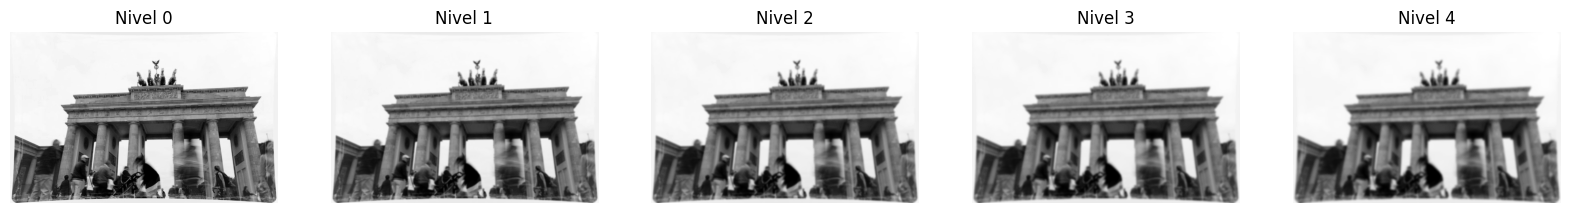

In [1]:
import numpy as np
from scipy.ndimage import convolve
from scipy.ndimage import gaussian_filter
import cv2
from matplotlib import pyplot as plt


def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114]).astype(np.uint8)

def gaussian_filter(sigma):
	size = 2*np.ceil(3*sigma)+1
	x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
	g = np.exp(-((x**2 + y**2)/(2.0*sigma**2))) / (2*np.pi*sigma**2)
	return g/g.sum()

def generate_octave(init_level, escalas, sigma):
    octave = [init_level]
    k = 2 ** (1/escalas)
    # Generar el kernel gaussiano
    kernel = gaussian_filter(k * sigma)
    for _ in range(escalas):
        # Convolucionar el nivel anterior con el kernel gaussiano
        next_level = convolve(octave[-1], kernel, mode='nearest')
        octave.append(next_level)
    return octave

imagen = cv2.imread('prueba1.jpg')
img = np.array(imagen)
img= rgb2gray(img)

escalas = 5 # número de escalas en la octava
sigma = 1.6

octave = generate_octave(img, escalas, sigma)
fig, axs = plt.subplots(1, escalas, figsize=(20, 10))
for i in range(escalas):
    axs[i].imshow(octave[i], cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f'Nivel {i}')
plt.show()

**Piramide Gausiana**

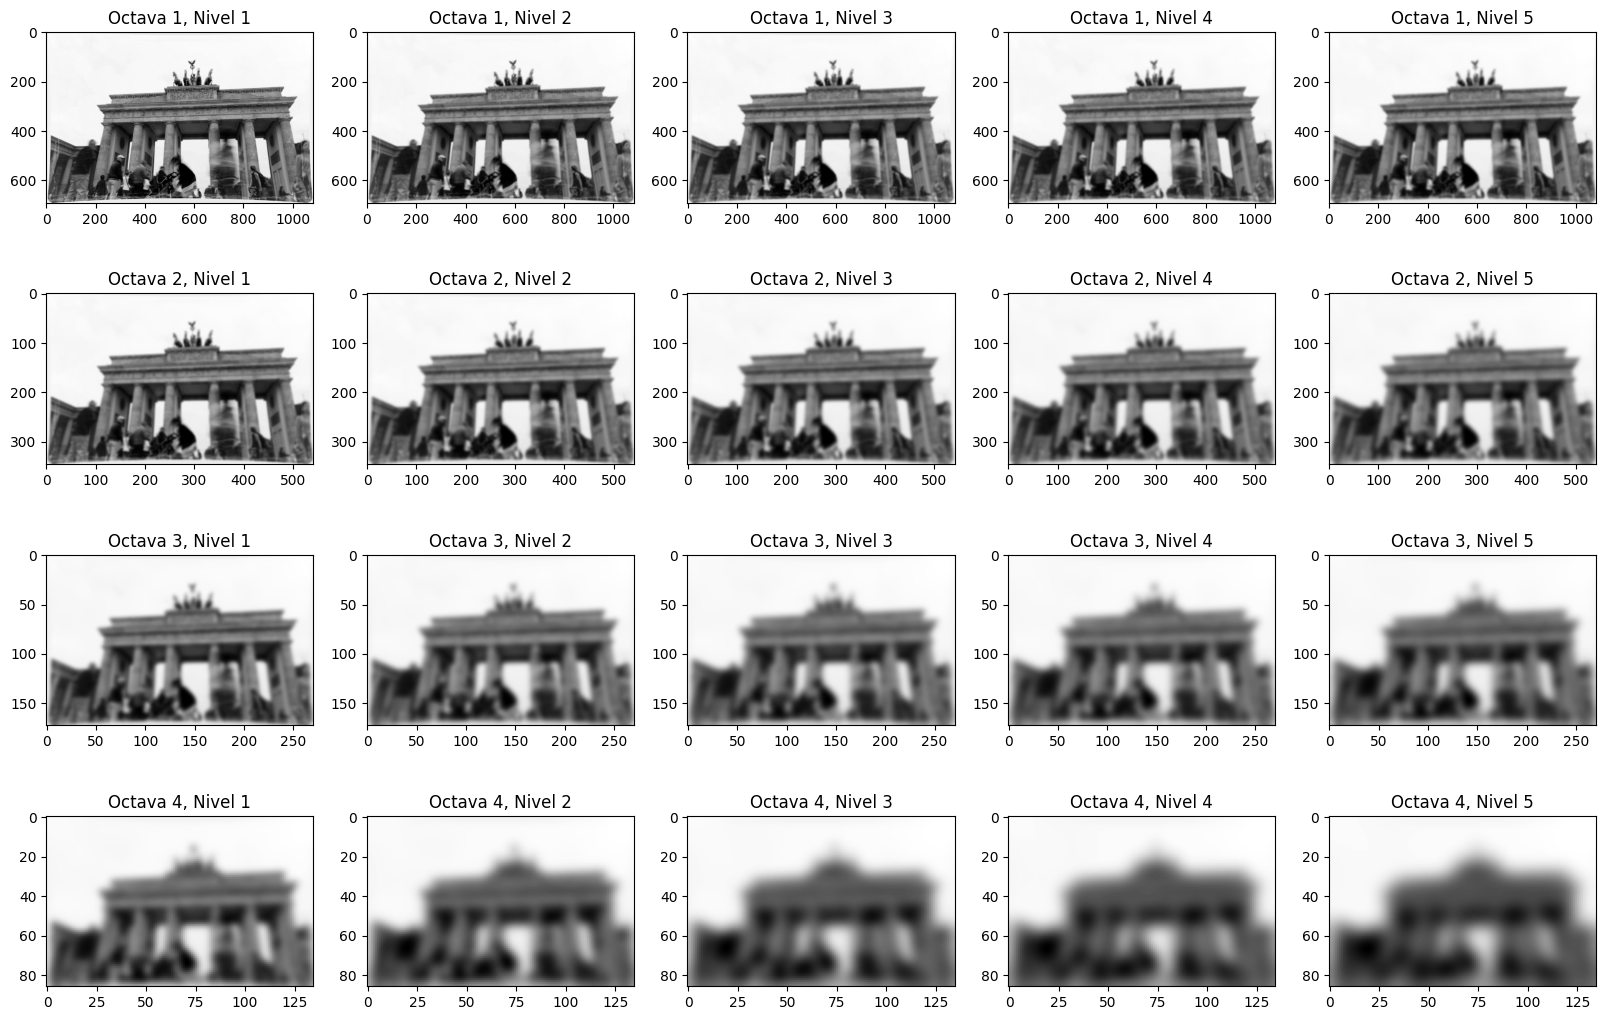

In [2]:
def generate_gaussian_pyramid(image, octaves, scales, sigma):
    pyramid = []
    for _ in range(octaves):
        octave = generate_octave(image, scales, sigma)
        pyramid.append(octave)
        # La siguiente imagen de la pirámide es la imagen de nivel 3 de la octava anterior
        image = octave[-3]
        # Reducir la resolución para la siguiente iteración
        image = cv2.resize(image, (image.shape[1] // 2, image.shape[0] // 2), interpolation=cv2.INTER_NEAREST)
    return pyramid


imagen = cv2.imread('prueba1.jpg')
img = np.array(imagen)
img = rgb2gray(img)

escalas = 5  # número de escalas en la octava
sigma = 1.6
octavas = 4  # número de octavas en la pirámide

gaussian_pyramid = generate_gaussian_pyramid(img, octavas, escalas, sigma)

# Visualizar la pirámide Gaussiana
fig, axs = plt.subplots(octavas, escalas, figsize=(20, 13))
for i in range(octavas):
    for j in range(escalas):
        axs[i, j].imshow(gaussian_pyramid[i][j], cmap='gray')
        #axs[i, j].axis('off')
        axs[i, j].set_title(f'Octava {i+1}, Nivel {j+1}')
plt.show()

**Diferencia Gausiana DoG**

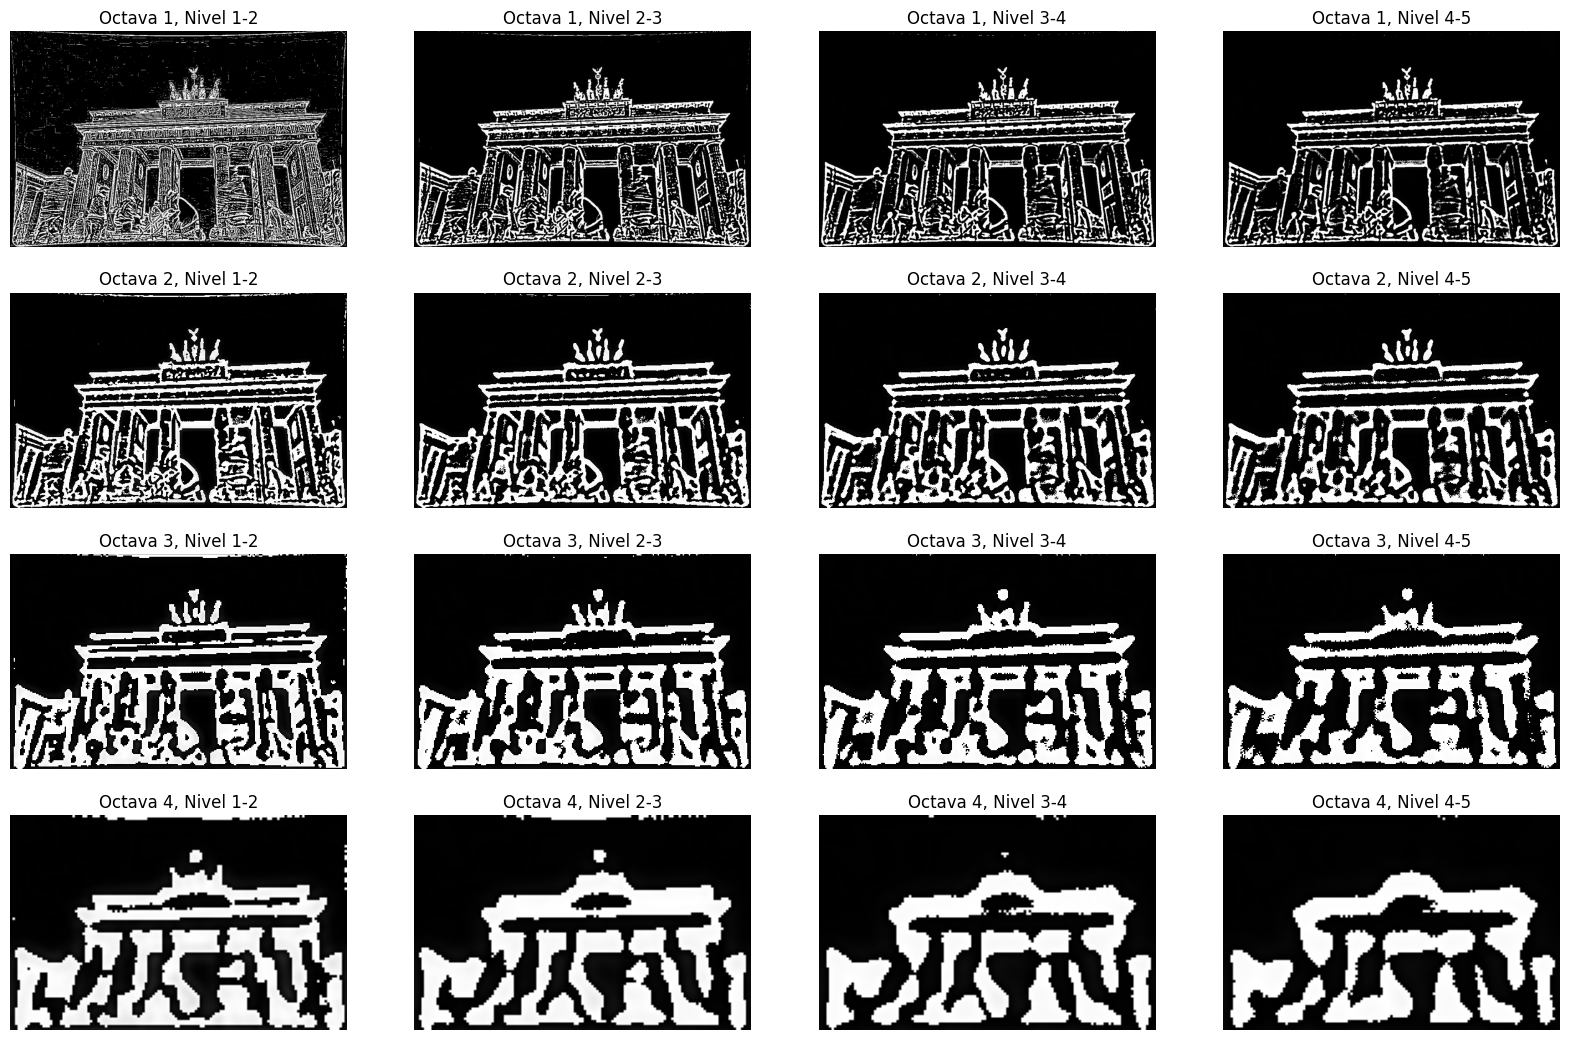

In [20]:
def generate_dog_pyramid(gaussian_pyramid):
    dog_pyramid = []
    for octave in gaussian_pyramid:
        dog_octave = [octave[i] - octave[i+1] for i in range(len(octave) - 1)]
        dog_pyramid.append(dog_octave)
    return dog_pyramid

# Construir la pirámide DoG
dog_pyramid = generate_dog_pyramid(gaussian_pyramid)

# Visualizar la pirámide DoG
fig, axs = plt.subplots(octavas, escalas - 1, figsize=(20, 13))
for i in range(octavas):
    for j in range(escalas - 1):
        axs[i, j].imshow(dog_pyramid[i][j], cmap='gray')
        axs[i, j].set_title(f'Octava {i+1}, Nivel {j+1}-{j+2}')
        axs[i, j].axis('off')
plt.show()

**detección de extremos**

In [4]:
def is_pixel_extremum(value, neighbors_same_scale, neighbors_adjacent_scales, threshold):
    # Comparar con los vecinos en la misma escala
    if value < np.min(neighbors_same_scale[1]) or value > np.max(neighbors_same_scale[1]):
        return False
    
    # Comparar con los vecinos en las escalas adyacentes
    for scale_neighbors in neighbors_adjacent_scales:
        if np.any(value <= np.min(scale_neighbors[1])) or np.any(value >= np.max(scale_neighbors[1])):
            return False

    # Comparar con el umbral de contraste
    contrast = np.abs(value - neighbors_same_scale[1][1])
    return np.any(contrast > threshold)


def refine_keypoint_location(scale_space, y, x):
    # Calcular las derivadas parciales de la intensidad en la ubicación del píxel
    dx = (scale_space[y, x + 1] - scale_space[y, x - 1]) / 2.0
    dy = (scale_space[y + 1, x] - scale_space[y - 1, x]) / 2.0
    ds = (scale_space[y, x] - scale_space[y, x]) / 2.0

    dxx = scale_space[y, x + 1] - 2 * scale_space[y, x] + scale_space[y, x - 1]
    dyy = scale_space[y + 1, x] - 2 * scale_space[y, x] + scale_space[y - 1, x]
    dss = scale_space[y, x] - 2 * scale_space[y, x] + scale_space[y, x]

    dxy = (scale_space[y + 1, x + 1] - scale_space[y + 1, x - 1] - scale_space[y - 1, x + 1] + scale_space[y - 1, x - 1]) / 4.0
    dxs = (scale_space[y, x + 1] - scale_space[y, x - 1] - scale_space[y, x + 1] + scale_space[y, x - 1]) / 4.0
    dys = (scale_space[y + 1, x] - scale_space[y - 1, x] - scale_space[y + 1, x] + scale_space[y - 1, x]) / 4.0

    # Resolver el sistema de ecuaciones lineales para obtener el desplazamiento en x, y, y la escala
    offset = np.linalg.lstsq(np.array([[dxx, dxy, dxs], [dxy, dyy, dys], [dxs, dys, dss]]), np.array([-dx, -dy, -ds]), rcond=None)[0]

    # Asegurarse de que las coordenadas resultantes sean enteras
    refined_location = (int(round(y + offset[0])), int(round(x + offset[1])))

    return refined_location

def find_keypoints(dog_pyramid, threshold=0.03):
    keypoints = []
    for octave in dog_pyramid:
        for i in range(1, len(octave) - 1):
            for y in range(1, octave[i].shape[0] - 1):
                for x in range(1, octave[i].shape[1] - 1):
                    pixel_value = octave[i][y, x]
                    
                    # Comparar con los vecinos en la misma imagen
                    neighbors_same_scale = [octave[i - 1][y-1:y+2, x-1:x+2], octave[i][y-1:y+2, x-1:x+2], octave[i + 1][y-1:y+2, x-1:x+2]]
                    
                    # Comparar con los vecinos en las imágenes adyacentes
                    neighbors_adjacent_scales = [octave[i - 1][y-1:y+2, x-1:x+2], octave[i][y-1:y+2, x-1:x+2], octave[i + 1][y-1:y+2, x-1:x+2]]

                    # Verificar si el píxel es un máximo o mínimo local
                    is_keypoint = is_pixel_extremum(pixel_value, neighbors_same_scale, neighbors_adjacent_scales, threshold)
                    
                    if is_keypoint:
                        # Refinar la ubicación del extremo con la expansión de la serie de Taylor
                        refined_location = refine_keypoint_location(octave[i], y, x)
                        keypoints.append((refined_location[0], refined_location[1], i))
                        
    return keypoints

# Encontrar puntos clave
threshold_contrast = 0.03
keypoints = find_keypoints(dog_pyramid, threshold=threshold_contrast)

# Imprimir resultados
print("Número de puntos clave encontrados:", len(keypoints))
print(keypoints)
    

C:\Users\Khoss\AppData\Local\Temp\ipykernel_21844\2952298614.py:27: RuntimeWarning: overflow encountered in scalar subtract
  dxs = (scale_space[y, x + 1] - scale_space[y, x - 1] - scale_space[y, x + 1] + scale_space[y, x - 1]) / 4.0
C:\Users\Khoss\AppData\Local\Temp\ipykernel_21844\2952298614.py:27: RuntimeWarning: overflow encountered in scalar add
  dxs = (scale_space[y, x + 1] - scale_space[y, x - 1] - scale_space[y, x + 1] + scale_space[y, x - 1]) / 4.0
C:\Users\Khoss\AppData\Local\Temp\ipykernel_21844\2952298614.py:28: RuntimeWarning: overflow encountered in scalar subtract
  dys = (scale_space[y + 1, x] - scale_space[y - 1, x] - scale_space[y + 1, x] + scale_space[y - 1, x]) / 4.0
C:\Users\Khoss\AppData\Local\Temp\ipykernel_21844\2952298614.py:28: RuntimeWarning: overflow encountered in scalar add
  dys = (scale_space[y + 1, x] - scale_space[y - 1, x] - scale_space[y + 1, x] + scale_space[y - 1, x]) / 4.0
C:\Users\Khoss\AppData\Local\Temp\ipykernel_21844\2952298614.py:18: Runtim

Número de puntos clave encontrados: 23901
[(117, 591, 1), (-6, 608, 1), (121, 581, 1), (-1780, 576, 1), (121, 597, 1), (126, 586, 1), (128, 573, 1), (128, 574, 1), (130, 575, 1), (131, 576, 1), (134, 596, 1), (70, 560, 1), (132, 599, 1), (280, 684, 1), (144, 584, 1), (133, 599, 1), (139, 597, 1), (140, 580, 1), (139, 594, 1), (173, 590, 1), (16, 606, 1), (160, 447, 1), (-358, 100, 1), (160, 595, 1), (151, 671, 1), (1665, 96, 1), (28, 620, 1), (107, 485, 1), (409, 853, 1), (155, 584, 1), (158, 570, 1), (158, 606, 1), (277, 596, 1), (160, 671, 1), (156, 669, 1), (157, 611, 1), (158, 610, 1), (158, 613, 1), (286, 616, 1), (160, 670, 1), (159, 612, 1), (161, 625, 1), (159, 656, 1), (161, 670, 1), (162, 521, 1), (1684, 169, 1), (161, 611, 1), (164, 608, 1), (100, 629, 1), (162, 675, 1), (165, 600, 1), (165, 606, 1), (242, 515, 1), (226, 614, 1), (102, 625, 1), (163, 624, 1), (166, 574, 1), (166, 486, 1), (160, 357, 1), (167, 607, 1), (233, 631, 1), (163, 650, 1), (290, 422, 1), (168, 556, 1

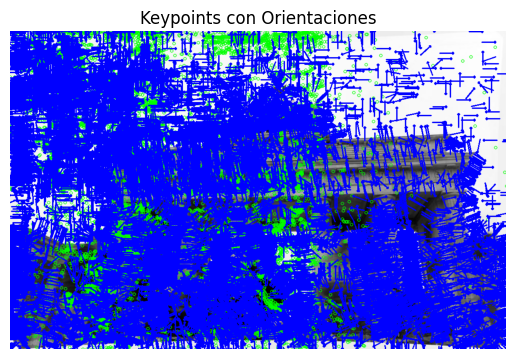

In [5]:
def calculate_keypoint_orientations(image, keypoints, radius_factor=3, num_bins=36, sigma=1.5):
    orientations = []

    # Calcular los gradientes de la imagen
    gradients_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
    gradients_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)

    # Obtener la magnitud y dirección de los gradientes
    magnitudes = np.sqrt(gradients_x**2 + gradients_y**2)
    angles = np.arctan2(gradients_y, gradients_x) * (180 / np.pi) % 360

    for keypoint in keypoints:
        y, x, _ = keypoint

        # Obtener la región alrededor del punto clave
        radius = int(radius_factor * sigma)
        region = magnitudes[y - radius:y + radius + 1, x - radius:x + radius + 1]

        # Calcular el histograma de orientaciones ponderado por las magnitudes
        histogram, bin_edges = np.histogram(angles[y - radius:y + radius + 1, x - radius:x + radius + 1],
                                            bins=num_bins, range=(0, 360), weights=region)

        # Encontrar la orientación dominante
        dominant_orientation = bin_edges[np.argmax(histogram)]

        # Guardar la orientación
        orientations.append((x, y, dominant_orientation))

    return orientations

# Calcular orientaciones de keypoints
radius_factor = 3
num_bins = 36
sigma_orientation = 1.5

orientations = calculate_keypoint_orientations(img, keypoints, radius_factor, num_bins, sigma_orientation)

# Visualizar los keypoints y sus orientaciones en la imagen original
image_with_keypoints = cv2.drawKeypoints(img, [cv2.KeyPoint(x, y, 1) for x, y, _ in keypoints], None, color=(0, 255, 0))
for x, y, orientation in orientations:
    angle_radians = np.radians(orientation)
    length = 30
    x2 = int(x + length * np.cos(angle_radians))
    y2 = int(y + length * np.sin(angle_radians))
    cv2.arrowedLine(image_with_keypoints, (x, y), (x2, y2), (0, 0, 255), 2)

# Mostrar la imagen con keypoints y orientaciones
plt.imshow(image_with_keypoints, cmap='gray')
plt.title('Keypoints con Orientaciones')
plt.axis('off')
plt.show()



Número de keypoints encontrados: 2894
(< cv2.KeyPoint 000002DFAA067090>, < cv2.KeyPoint 000002DFADB00A80>, < cv2.KeyPoint 000002DFADB02A00>, < cv2.KeyPoint 000002DFADB02C40>, < cv2.KeyPoint 000002DFADB00BD0>, < cv2.KeyPoint 000002DFADB00450>, < cv2.KeyPoint 000002DFA505BF00>, < cv2.KeyPoint 000002DFA505BE70>, < cv2.KeyPoint 000002DFA505BF30>, < cv2.KeyPoint 000002DFA505BFC0>, < cv2.KeyPoint 000002DFA505BE40>, < cv2.KeyPoint 000002DFA505BF90>, < cv2.KeyPoint 000002DFA505A0D0>, < cv2.KeyPoint 000002DFA505BCC0>, < cv2.KeyPoint 000002DFAA08AFA0>, < cv2.KeyPoint 000002DFAA0880F0>, < cv2.KeyPoint 000002DFAA08BA20>, < cv2.KeyPoint 000002DFAA088630>, < cv2.KeyPoint 000002DFAA0897A0>, < cv2.KeyPoint 000002DFAA0888A0>, < cv2.KeyPoint 000002DFAA08B090>, < cv2.KeyPoint 000002DFAA08A070>, < cv2.KeyPoint 000002DFAA088450>, < cv2.KeyPoint 000002DFAA08AF70>, < cv2.KeyPoint 000002DFAA08B690>, < cv2.KeyPoint 000002DFAA08BB70>, < cv2.KeyPoint 000002DFAA089950>, < cv2.KeyPoint 000002DFAA089AD0>, < cv2.Key

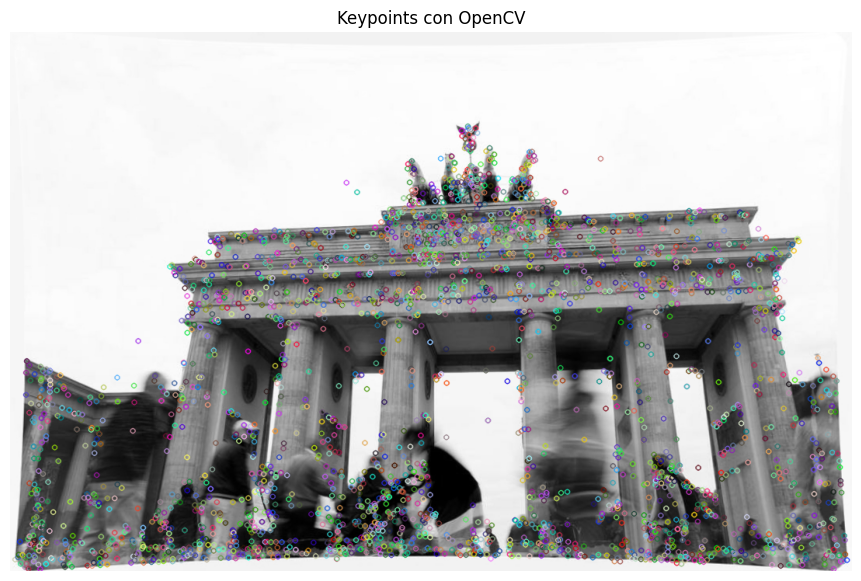

In [15]:
import cv2
import matplotlib.pyplot as plt

# Cargar la imagen
image = cv2.imread('prueba1.jpg', cv2.IMREAD_GRAYSCALE)

# Crear un objeto SIFT
sift = cv2.SIFT_create()

# Detectar keypoints y calcular descriptores
kpoints, _ = sift.detectAndCompute(image, None)

print("Número de keypoints encontrados:", len(kpoints))
print(kpoints)

# Dibujar los keypoints en la imagen
image_with_keypoints = cv2.drawKeypoints(image, kpoints, None)

# Mostrar la imagen con keypoints
plt.figure(figsize=(15, 7))
plt.imshow(image_with_keypoints, cmap='gray')
plt.title('Keypoints con OpenCV')
plt.axis('off')
plt.show()

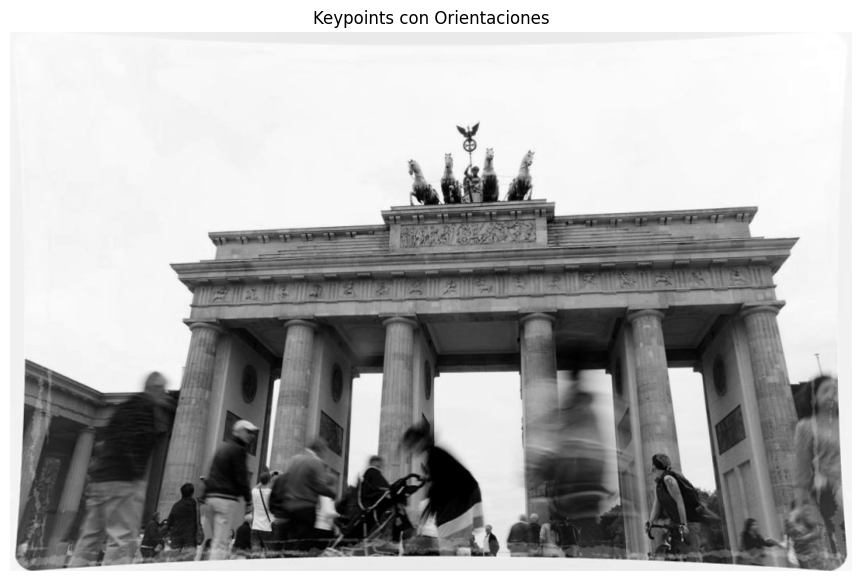

In [18]:
def calculate_keypoint_orientations(image, keypoints, radius_factor=3, num_bins=36, sigma=1.5):
    orientations = []

    # Calcular los gradientes de la imagen
    gradients_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
    gradients_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)

    # Obtener la magnitud y dirección de los gradientes
    magnitudes, angles = cv2.cartToPolar(gradients_x, gradients_y, angleInDegrees=True)

    for keypoint in keypoints:
        x, y = keypoint.pt

        # Obtener la región alrededor del punto clave
        radius = int(radius_factor * sigma)
        region_magnitudes = magnitudes[int(y) - radius:int(y) + radius + 1, int(x) - radius:int(x) + radius + 1]
        region_angles = angles[int(y) - radius:int(y) + radius + 1, int(x) - radius:int(x) + radius + 1]
    
        # Calcular el histograma de orientaciones ponderado por las magnitudes
        histogram, bin_edges = np.histogram(region_angles, bins=num_bins, range=(0, 360), weights=region_magnitudes)
        
        # Encontrar la orientación dominante
        dominant_orientation = bin_edges[np.argmax(histogram)]

        # Guardar la orientación
        orientations.append((x, y, dominant_orientation))

    return orientation

# Calcular orientaciones de keypoints
radius_factor = 3
num_bins = 36
sigma_orientation = 1.5

orientations = calculate_keypoint_orientations(img, kpoints, radius_factor, num_bins, sigma_orientation)

# Visualizar los keypoints y sus orientaciones en la imagen original
image_with_orientations = img.copy()

for x, y, orientation in orientations:
    angle_radians = np.radians(orientation)
    length = 30
    x2 = int(x + length * np.cos(angle_radians))
    y2 = int(y + length * np.sin(angle_radians))
    cv2.arrowedLine(image_with_orientations, (int(x), int(y)), (x2, y2), (0, 0, 255), 2)

# Mostrar la imagen con keypoints y orientaciones
plt.figure(figsize=(15, 7))
plt.imshow(image_with_orientations, cmap='gray')
plt.title('Keypoints con Orientaciones')
plt.axis('off')
plt.show()

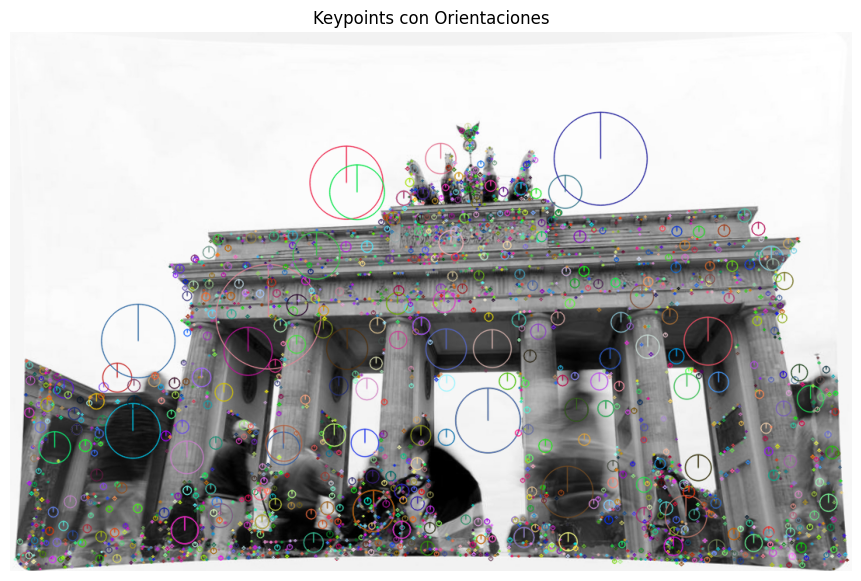

In [19]:
import cv2
import numpy as np

# Cargar la imagen
image = cv2.imread('prueba1.jpg', cv2.IMREAD_GRAYSCALE)

# Crear un objeto SIFT
sift = cv2.SIFT_create()

# Detectar keypoints y calcular descriptores
kp, descriptors = sift.detectAndCompute(image, None)

# Calcular la orientación de los keypoints
for keypoint in kp:
    x, y = np.int32(keypoint.pt)
    size = keypoint.size
    angle = keypoint.angle
    region = np.int32(np.round(1.5 * size))
    gradient_region = image[y - region:y + region, x - region:x + region]

    gradients_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
    gradients_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)

    # Calcular la orientación como la dirección del gradiente máximo
    keypoint.angle = np.degrees(np.arctan2(np.sum(gradients_y), np.sum(gradients_x)))
    
image_with_orientations = cv2.drawKeypoints(image, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


plt.figure(figsize=(15, 7))
plt.imshow(image_with_orientations, cmap='gray')
plt.title('Keypoints con Orientaciones')
plt.axis('off')
plt.show()
